In [198]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
import upsetplot
from dataclasses import dataclass

from ncbi.datasets.openapi import ApiClient as DatasetsApiClient
from ncbi.datasets.openapi import ApiException as DatasetsApiException
from ncbi.datasets import GeneApi as DatasetsGeneApi
from ncbi.datasets.openapi.models import V1GeneMatch

In [199]:
os.chdir("/data/scratch/projects/punim1068/Sepsis-methylation")

In [200]:
%matplotlib inline
mpl.rc_file_defaults()
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [4]:
valid_refs_path = Path("results/alignment/valid_references_list.txt")
valid_refs = valid_refs_path.read_text().splitlines()
len(valid_refs)

60

Map the reference accessions to their gene names

In [5]:
class Gene:
    def __init__(self, gene: Union[str, V1GeneMatch]):
        if isinstance(gene, str):
            with DatasetsApiClient() as api_client:
                gene_api = DatasetsGeneApi(api_client)
                # Retrieve metadata for genes with the given transcript and protein accessions
                gene_reply = gene_api.gene_metadata_by_accession([accession])
                if len(gene_reply.genes) > 1:
                    raise ValueError("Got more than 1 transcript")
                self._record = gene_reply.genes[0]["gene"]
        elif isinstance(gene, V1GeneMatch):
            self._record = gene["gene"]
            self._acc = gene["query"][0]
        else:
            raise ValueError("Expected accession string or gene dictionary")
        
    def __hash__(self):
        return hash(self._record)
    
    def __lt__(self, other: "Gene"):
        return self.name < other.name
    
    @property
    def transcript_accession(self) -> str:
        return self._acc
    
    @property
    def name(self) -> str:
        return self._record["symbol"]
    
    @property
    def description(self) -> str:
        return self._record["description"]

In [6]:
# Taken from https://www.ncbi.nlm.nih.gov/datasets/docs/v1/how-tos/genes/get-gene-metadata/
genes: List[Gene] = []
with DatasetsApiClient() as api_client:
    gene_api = DatasetsGeneApi(api_client)
    # Retrieve metadata for genes with the given transcript and protein accessions
    gene_reply = gene_api.gene_metadata_by_accession(valid_refs)
    for gene in gene_reply.genes:
        genes.append(Gene(gene))

In [7]:
for g in sorted(genes):
    print(f"{g.name:<8}: {g.description}")

ACTB    : actin beta
B2M     : beta-2-microglobulin
CD74    : CD74 molecule
CFL1    : cofilin 1
EEF1A1  : eukaryotic translation elongation factor 1 alpha 1
EEF1G   : eukaryotic translation elongation factor 1 gamma
EIF1    : eukaryotic translation initiation factor 1
FAU     : FAU ubiquitin like and ribosomal protein S30 fusion
FTH1    : ferritin heavy chain 1
FTL     : ferritin light chain
HBA1    : hemoglobin subunit alpha 1
HBA2    : hemoglobin subunit alpha 2
HBB     : hemoglobin subunit beta
HLA-B   : major histocompatibility complex, class I, B
HLA-DRA : major histocompatibility complex, class II, DR alpha
IFITM1  : interferon induced transmembrane protein 1
IFITM2  : interferon induced transmembrane protein 2
OAZ1    : ornithine decarboxylase antizyme 1
PFN1    : profilin 1
RACK1   : receptor for activated C kinase 1
RPL12   : ribosomal protein L12
RPL13   : ribosomal protein L13
RPL13A  : ribosomal protein L13a
RPL18   : ribosomal protein L18
RPL18A  : ribosomal protein L18a
R

In [8]:
c = 0
non_ribosomal = set()
for g in sorted(genes):
    if "ribosom" in g.description:
        continue
    c += 1
    non_ribosomal.add(g.name)
    print(f"{g.name:<8}: {g.description}")

ACTB    : actin beta
B2M     : beta-2-microglobulin
CD74    : CD74 molecule
CFL1    : cofilin 1
EEF1A1  : eukaryotic translation elongation factor 1 alpha 1
EEF1G   : eukaryotic translation elongation factor 1 gamma
EIF1    : eukaryotic translation initiation factor 1
FTH1    : ferritin heavy chain 1
FTL     : ferritin light chain
HBA1    : hemoglobin subunit alpha 1
HBA2    : hemoglobin subunit alpha 2
HBB     : hemoglobin subunit beta
HLA-B   : major histocompatibility complex, class I, B
HLA-DRA : major histocompatibility complex, class II, DR alpha
IFITM1  : interferon induced transmembrane protein 1
IFITM2  : interferon induced transmembrane protein 2
OAZ1    : ornithine decarboxylase antizyme 1
PFN1    : profilin 1
RACK1   : receptor for activated C kinase 1
S100A9  : S100 calcium binding protein A9
SH3BGRL3: SH3 domain binding glutamate rich protein like 3
TMSB10  : thymosin beta 10
TMSB4X  : thymosin beta 4 X-linked
TPT1    : tumor protein, translationally-controlled 1


In [9]:
acc2gene = {g.transcript_accession: g.name for g in genes}

## Nanocompore results

In [10]:
infection = {
    "GE031_55_2C": "Bacterial", 
    "GE044_56_5D": "Bacterial and Viral", 
    "6201_8_0_P1": "Probable Viral", 
    "6679_23_0_P1": "Probable Bacterial"
}

In [11]:
frames = []
keep_cols = ["pvalue", "peak", "ref_kmer", "LOR"]
max_pval = 0.01
peaks_only = True
only_non_ribosomal = False
min_abs_lor = 2.0

for sample in infection:
    gmm_tsv = f"results/nanocompore/{sample}/nanocompore_results_GMM_context_0.tsv"
    gmm_df = pd.read_csv(gmm_tsv, sep="\t")
    gmm_df["ref_id"] = [acc2gene[x] for x in gmm_df["ref_id"]]
    gmm_df.set_index(["ref_id", "pos"], verify_integrity=True, inplace=True)
    df = gmm_df.query(f"pvalue < @max_pval and (LOR>@min_abs_lor or LOR<-@min_abs_lor)")
    if peaks_only:
        df = df.query("peak == True")
    if only_non_ribosomal:
        df = df.query("ref_id in @non_ribosomal")
    df["sample"] = sample
    df.reset_index(inplace=True)
    frames.append(df)
    
ncomp_df = pd.concat(frames)

In [12]:
ncomp_df.groupby(["sample"]).count()

,ref_id,pos,pvalue,peak,ref_kmer,LOR
sample,,,,,,
6201_8_0_P1,51,51,51,51,51,51
6679_23_0_P1,132,132,132,132,132,132
GE031_55_2C,113,113,113,113,113,113
GE044_56_5D,110,110,110,110,110,110


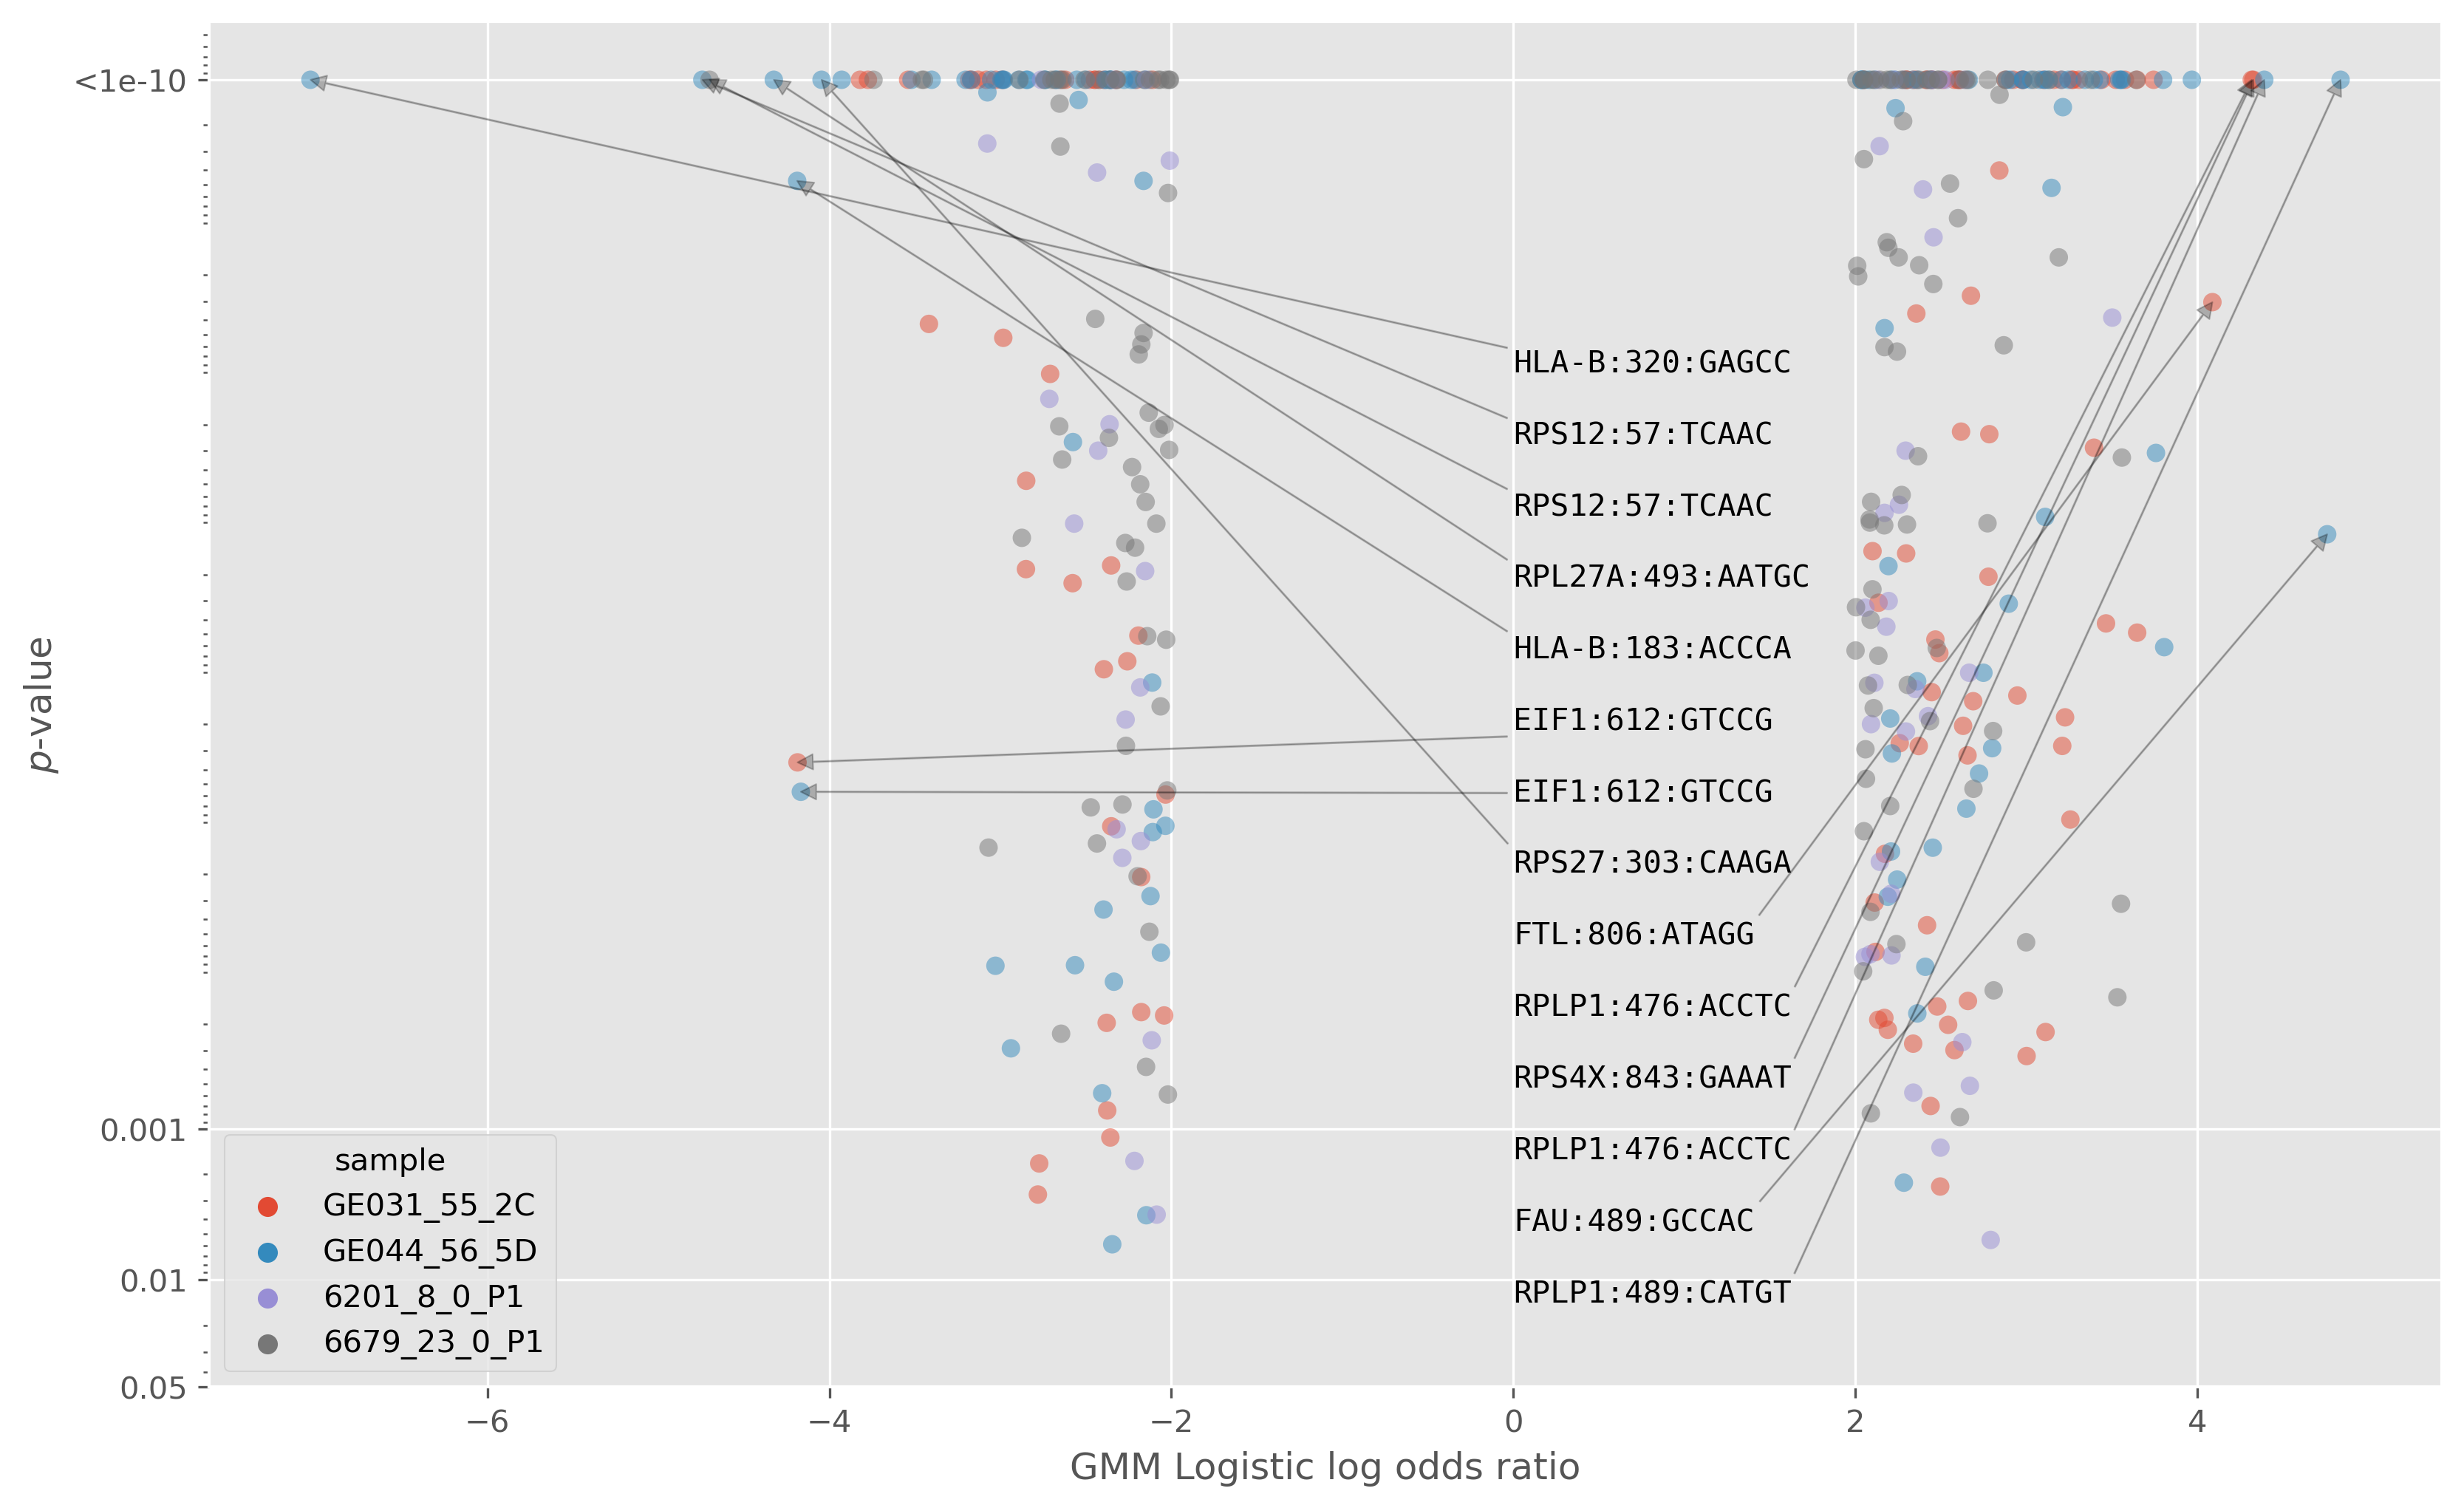

In [13]:
x = "LOR"
y = "pvalue"
hue = "sample"
pval_cap = 1e-10  # stops axes from getting huge!
data = ncomp_df
data[y] = [max(p, pval_cap) for p in data[y]]

fig, ax = plt.subplots()
sns.scatterplot(data=data, x=x, y=y, hue=hue, linewidth=0, ax=ax, alpha=0.5)
# ax.set_ylim((5e-21, 0.99))
ax.invert_yaxis()
ax.set_yscale("logit")
ticks = [0.05, 0.01, 0.001, pval_cap]
ax.set_yticks(ticks)
ticks[-1] = f"<{ticks[-1]}"
ax.set_yticklabels(ticks)
ax.set_ylabel("$p$-value")
ax.set_xlabel("GMM Logistic log odds ratio")


ypos = max_pval
xpos = 0#min_abs_lor
for _, row in data.query("LOR>=4 or LOR<=-4").sort_values(x, ascending=False).iterrows():
    label = f'{row["ref_id"]}:{row["pos"]}:{row["ref_kmer"]}'
    xx = row[x]
    yy = row[y]
    kmer = row["ref_kmer"]
#     alpha = 1 if kmer == "ACAGG" else 0.15
    ax.annotate(label, 
                xy=(xx, yy), xycoords='data', 
                font="monospace",
                xytext=(xpos, ypos), textcoords='data',
                horizontalalignment="left",
                verticalalignment="top",
                arrowprops=dict( 
                    color="black", 
                    alpha=0.25, 
#                     shrink=0.1, 
                    width=0.25, 
                    headlength=5, 
                    headwidth=5,
                ))
    ypos = ypos/3

In [14]:
data.query("LOR<=-4 or LOR>=4").sort_values(by="ref_id")

,ref_id,pos,pvalue,peak,ref_kmer,LOR,sample
99,EIF1,612,3.582518e-06,True,GTCCG,-4.186083,GE031_55_2C
90,EIF1,612,5.628644e-06,True,GTCCG,-4.166665,GE044_56_5D
54,FAU,489,1.077229e-07,True,GCCAC,4.759909,GE044_56_5D
0,FTL,806,3.044951e-09,True,ATAGG,4.088672,GE031_55_2C
71,HLA-B,183,4.726366e-10,True,ACCCA,-4.188030,GE044_56_5D
77,HLA-B,320,1.000000e-10,True,GAGCC,-7.034514,GE044_56_5D
11,RPL27A,493,1.000000e-10,True,AATGC,-4.324830,GE044_56_5D
32,RPLP1,476,1.000000e-10,True,ACCTC,4.318757,GE031_55_2C
22,RPLP1,476,1.000000e-10,True,ACCTC,4.391987,GE044_56_5D
23,RPLP1,489,1.000000e-10,True,CATGT,4.838215,GE044_56_5D


In [15]:
contents = dict()
for sample in infection:
    d = ncomp_df.query(f"sample=='{sample}'")
    contents[sample] = list(zip(d["ref_id"], d["pos"]))

In [16]:
upset_data = upsetplot.from_contents(contents)

[]

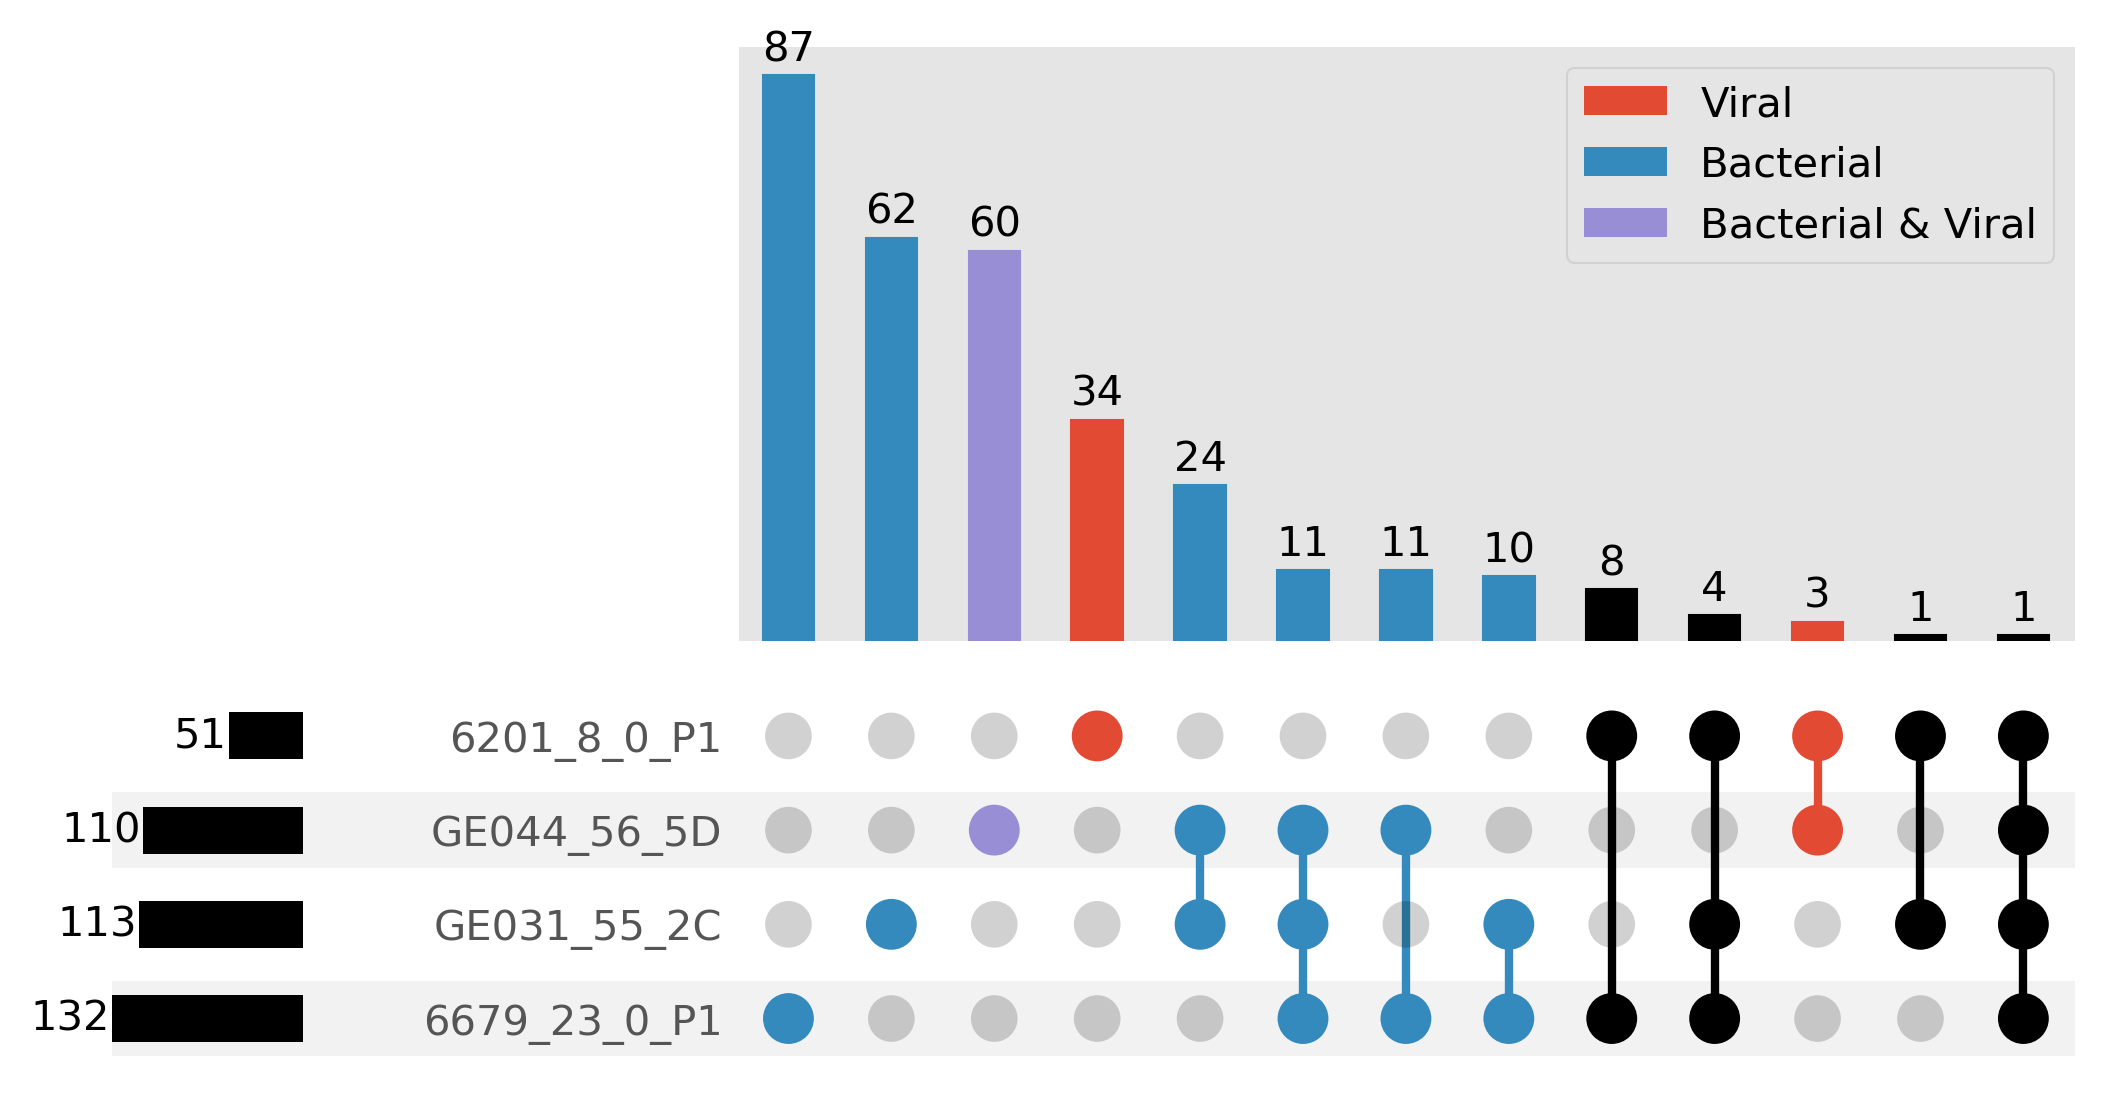

In [17]:
fig, ax = plt.subplots()
p = upsetplot.UpSet(upset_data, sort_by="cardinality", orientation="horizontal", show_counts=True)
# p.style_subsets(present=["GE044_56_5D"], label="Bacterial & Viral", facecolor=colours[2])
p.style_subsets(present=["6201_8_0_P1"], absent=["GE031_55_2C", "6679_23_0_P1"], label="Viral", facecolor=colours[0])
p.style_subsets(present=["6679_23_0_P1"], absent=["6201_8_0_P1"], label="Bacterial", facecolor=colours[1])
p.style_subsets(present=["GE031_55_2C"], absent=["6201_8_0_P1"], label="Bacterial", facecolor=colours[1])
p.style_subsets(present=["GE044_56_5D"], absent=[i for i in infection if i!="GE044_56_5D"], label="Bacterial & Viral", facecolor=colours[2])
p = p.plot(fig=fig)
p["intersections"].set_ylabel("")
p["intersections"].set_yticks([])
ax.axis("off")
p["totals"].set_xticks([])

In [18]:
infection

{'GE031_55_2C': 'Bacterial',
 'GE044_56_5D': 'Bacterial and Viral',
 '6201_8_0_P1': 'Probable Viral',
 '6679_23_0_P1': 'Probable Bacterial'}

In [19]:
def_bact = upset_data.at[(True, False, False, True)].reset_index(drop=True).rename(columns={"level_0": "gene", "level_1": "pos"})

/tmp/ipykernel_2475/1090239482.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  def_bact = upset_data.at[(True, False, False, True)].reset_index(drop=True).rename(columns={"level_0": "gene", "level_1": "pos"})


In [20]:
for _, row in def_bact.iterrows():
    gene = row["gene"]
    pos = row["pos"]
    lors = list(df.query("pos==@pos and ref_id==@gene")["LOR"])
    print(gene, pos, lors)

RPLP1 462 [-2.019113553078605]
RPLP2 445 [2.373714046212985]
RPS8 656 [2.135101881018461]
RPS16 513 [2.80948409875706]
RPS20 503 [3.5591503474391515]
RPS27 306 [-2.1622121685528057]
FTH1 866 [3.190249103441764]
FTH1 876 [2.1077307828533347]
B2M 916 [2.301103733164264]
TMSB4X 604 [2.485398654717975]


In [21]:
viral = upset_data.at[(False, True, True, False)].reset_index(drop=True).rename(columns={"level_0": "gene", "level_1": "pos"})

/tmp/ipykernel_2475/2267945574.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  viral = upset_data.at[(False, True, True, False)].reset_index(drop=True).rename(columns={"level_0": "gene", "level_1": "pos"})


In [22]:
viral

,gene,pos
0,HLA-B,430
1,HLA-B,653
2,HLA-B,1303


In [23]:
upset_data.at[(True, True, True, True)]

/tmp/ipykernel_2475/1093100809.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  upset_data.at[(True, True, True, True)]


,,,,level_0,level_1
GE031_55_2C,GE044_56_5D,6201_8_0_P1,6679_23_0_P1,,
True,True,True,True,TMSB10,377


## xPore results

In [24]:
frames = []
max_pval = 0.01
only_non_ribosomal = False
min_abs_diff = 0.0

for sample in infection:
    xpore_tsv = f"results/xpore/diffmod/{sample}/diffmod.table"
    xpore_df = pd.read_csv(xpore_tsv)
    xpore_df.rename(
        columns={
            "id": "ref_id", 
            "position": "pos", 
            "kmer": "ref_kmer",
            "diff_mod_rate_CTRL_vs_TEST": "diff_mod_rate",
            "pval_CTRL_vs_TEST": "pvalue",
            "z_score_CTRL_vs_TEST": "zscore"
        },
        inplace=True
    )
    xpore_df["ref_id"] = [acc2gene[x] for x in xpore_df["ref_id"]]
    xpore_df.set_index(["ref_id", "pos"], verify_integrity=True, inplace=True)
    df = xpore_df.query(f"pvalue < @max_pval and (diff_mod_rate>@min_abs_diff or diff_mod_rate<-@min_abs_diff)").copy()
    if only_non_ribosomal:
        df = df.query("ref_id in @non_ribosomal")
    df["sample"] = sample
    df.reset_index(inplace=True)
    frames.append(df)
    
xpore_df = pd.concat(frames)

In [25]:
xpore_df

,ref_id,pos,ref_kmer,diff_mod_rate,pvalue,zscore,mod_rate_CTRL-rep1,mod_rate_TEST-rep1,coverage_CTRL-rep1,coverage_TEST-rep1,mu_unmod,mu_mod,sigma2_unmod,sigma2_mod,conf_mu_unmod,conf_mu_mod,mod_assignment,sample
0,RPL23,170,CCGCT,-0.062383,2.295839e-03,-3.049027,0.937591,0.999974,140.0,39.0,87.315798,92.074664,8.210147,3.855078,0.425004,0.301808,higher,GE031_55_2C
1,RPL23,407,TTGCA,-0.249628,2.907352e-03,-2.977368,0.065264,0.314892,212.0,32.0,94.800909,89.816660,3.547985,7.144756,0.487945,0.368743,lower,GE031_55_2C
2,RPL23,199,GCCAC,-0.062684,1.612043e-03,-3.153719,0.937291,0.999976,149.0,41.0,71.887645,68.678923,1.956925,2.011138,0.917844,0.156316,lower,GE031_55_2C
3,RPL23,365,CAGGA,0.137606,6.130935e-08,5.414940,0.137633,0.000027,184.0,37.0,90.900817,112.127914,33.001207,70.599417,0.340095,0.079506,higher,GE031_55_2C
4,RPL23,144,GATCA,0.136513,2.368312e-06,4.719151,0.136539,0.000026,141.0,39.0,96.116584,86.303931,13.186086,30.528630,0.639912,0.209952,lower,GE031_55_2C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5045,HLA-DRA,749,GGTGG,-0.310452,1.356643e-14,-7.700378,0.655146,0.965598,229.0,52.0,101.866481,86.067119,94.718938,25.500739,0.804665,0.166614,lower,6679_23_0_P1
5046,HLA-DRA,448,ACGTC,0.257714,1.010476e-36,12.657995,0.257734,0.000021,462.0,48.0,76.330347,80.063270,4.097599,12.276482,0.544220,0.536928,higher,6679_23_0_P1
5047,HLA-DRA,641,CTGGG,0.101613,4.345794e-07,5.053151,0.101632,0.000019,226.0,52.0,103.474042,99.483254,2.945378,11.521918,0.645761,0.588826,lower,6679_23_0_P1
5048,HLA-DRA,380,TCCGA,-0.192596,9.547628e-06,-4.427173,0.734591,0.927187,497.0,45.0,79.893032,85.931654,9.531726,2.697353,0.474772,0.144998,higher,6679_23_0_P1


In [26]:
def symlogspace(arr, n_bins, zero_eps=0.1, padding=0):
    """
    Splits a data range into log-like bins but with 0 and negative values taken into account.
    Can be used together with matplotlib 'symlog' axis sacale (i.e. ax.set_xscale('symlog'))
    Feel free to contribute: https://gist.github.com/artoby/0bcf790cfebed5805fbbb6a9853fe5d5
    """
    a = min(arr) / (1 + padding)
    b = max(arr) * (1 + padding)
        
    if a > b:
        a, b = b, a
        
    neg_range_log = None
    if a < -zero_eps:
        neg_range_log = [np.log10(-a), np.log10(zero_eps)]
    
    # Add a value to zero bin edges in case a lies within [-zero_eps; zero_eps) - so an additional bin will be added before positive range
    zero_bin_edges = []
    if -zero_eps <= a < zero_eps:
        zero_bin_edges = [a]
            
    pos_range_log = None
    if b > zero_eps:
        pos_range_log = [np.log10(max(a, zero_eps)), np.log10(b)]

    nonzero_n_bin_edges = n_bins + 1 - len(zero_bin_edges)
    
    neg_range_log_size = (neg_range_log[0] - neg_range_log[1]) if neg_range_log is not None else 0
    pos_range_log_size = (pos_range_log[1] - pos_range_log[0]) if pos_range_log is not None else 0
    
    range_log_size = neg_range_log_size + pos_range_log_size
    pos_n_bin_edges_raw = int(round(nonzero_n_bin_edges * (pos_range_log_size/range_log_size))) if range_log_size > 0 else 0
    # Ensure each range has at least 2 edges if it's not empty
    neg_n_bin_edges = max(2, nonzero_n_bin_edges - pos_n_bin_edges_raw) if neg_range_log_size > 0 else 0
    pos_n_bin_edges = max(2, nonzero_n_bin_edges - neg_n_bin_edges) if pos_range_log_size > 0 else 0
    
    neg_bin_edges = []
    if neg_n_bin_edges > 0:
        neg_bin_edges = list(-np.logspace(neg_range_log[0], neg_range_log[1], neg_n_bin_edges))
        
    pos_bin_edges = []
    if pos_n_bin_edges > 0:
        pos_bin_edges = list(np.logspace(pos_range_log[0], pos_range_log[1], pos_n_bin_edges))
    
    result = neg_bin_edges + zero_bin_edges + pos_bin_edges
    return result

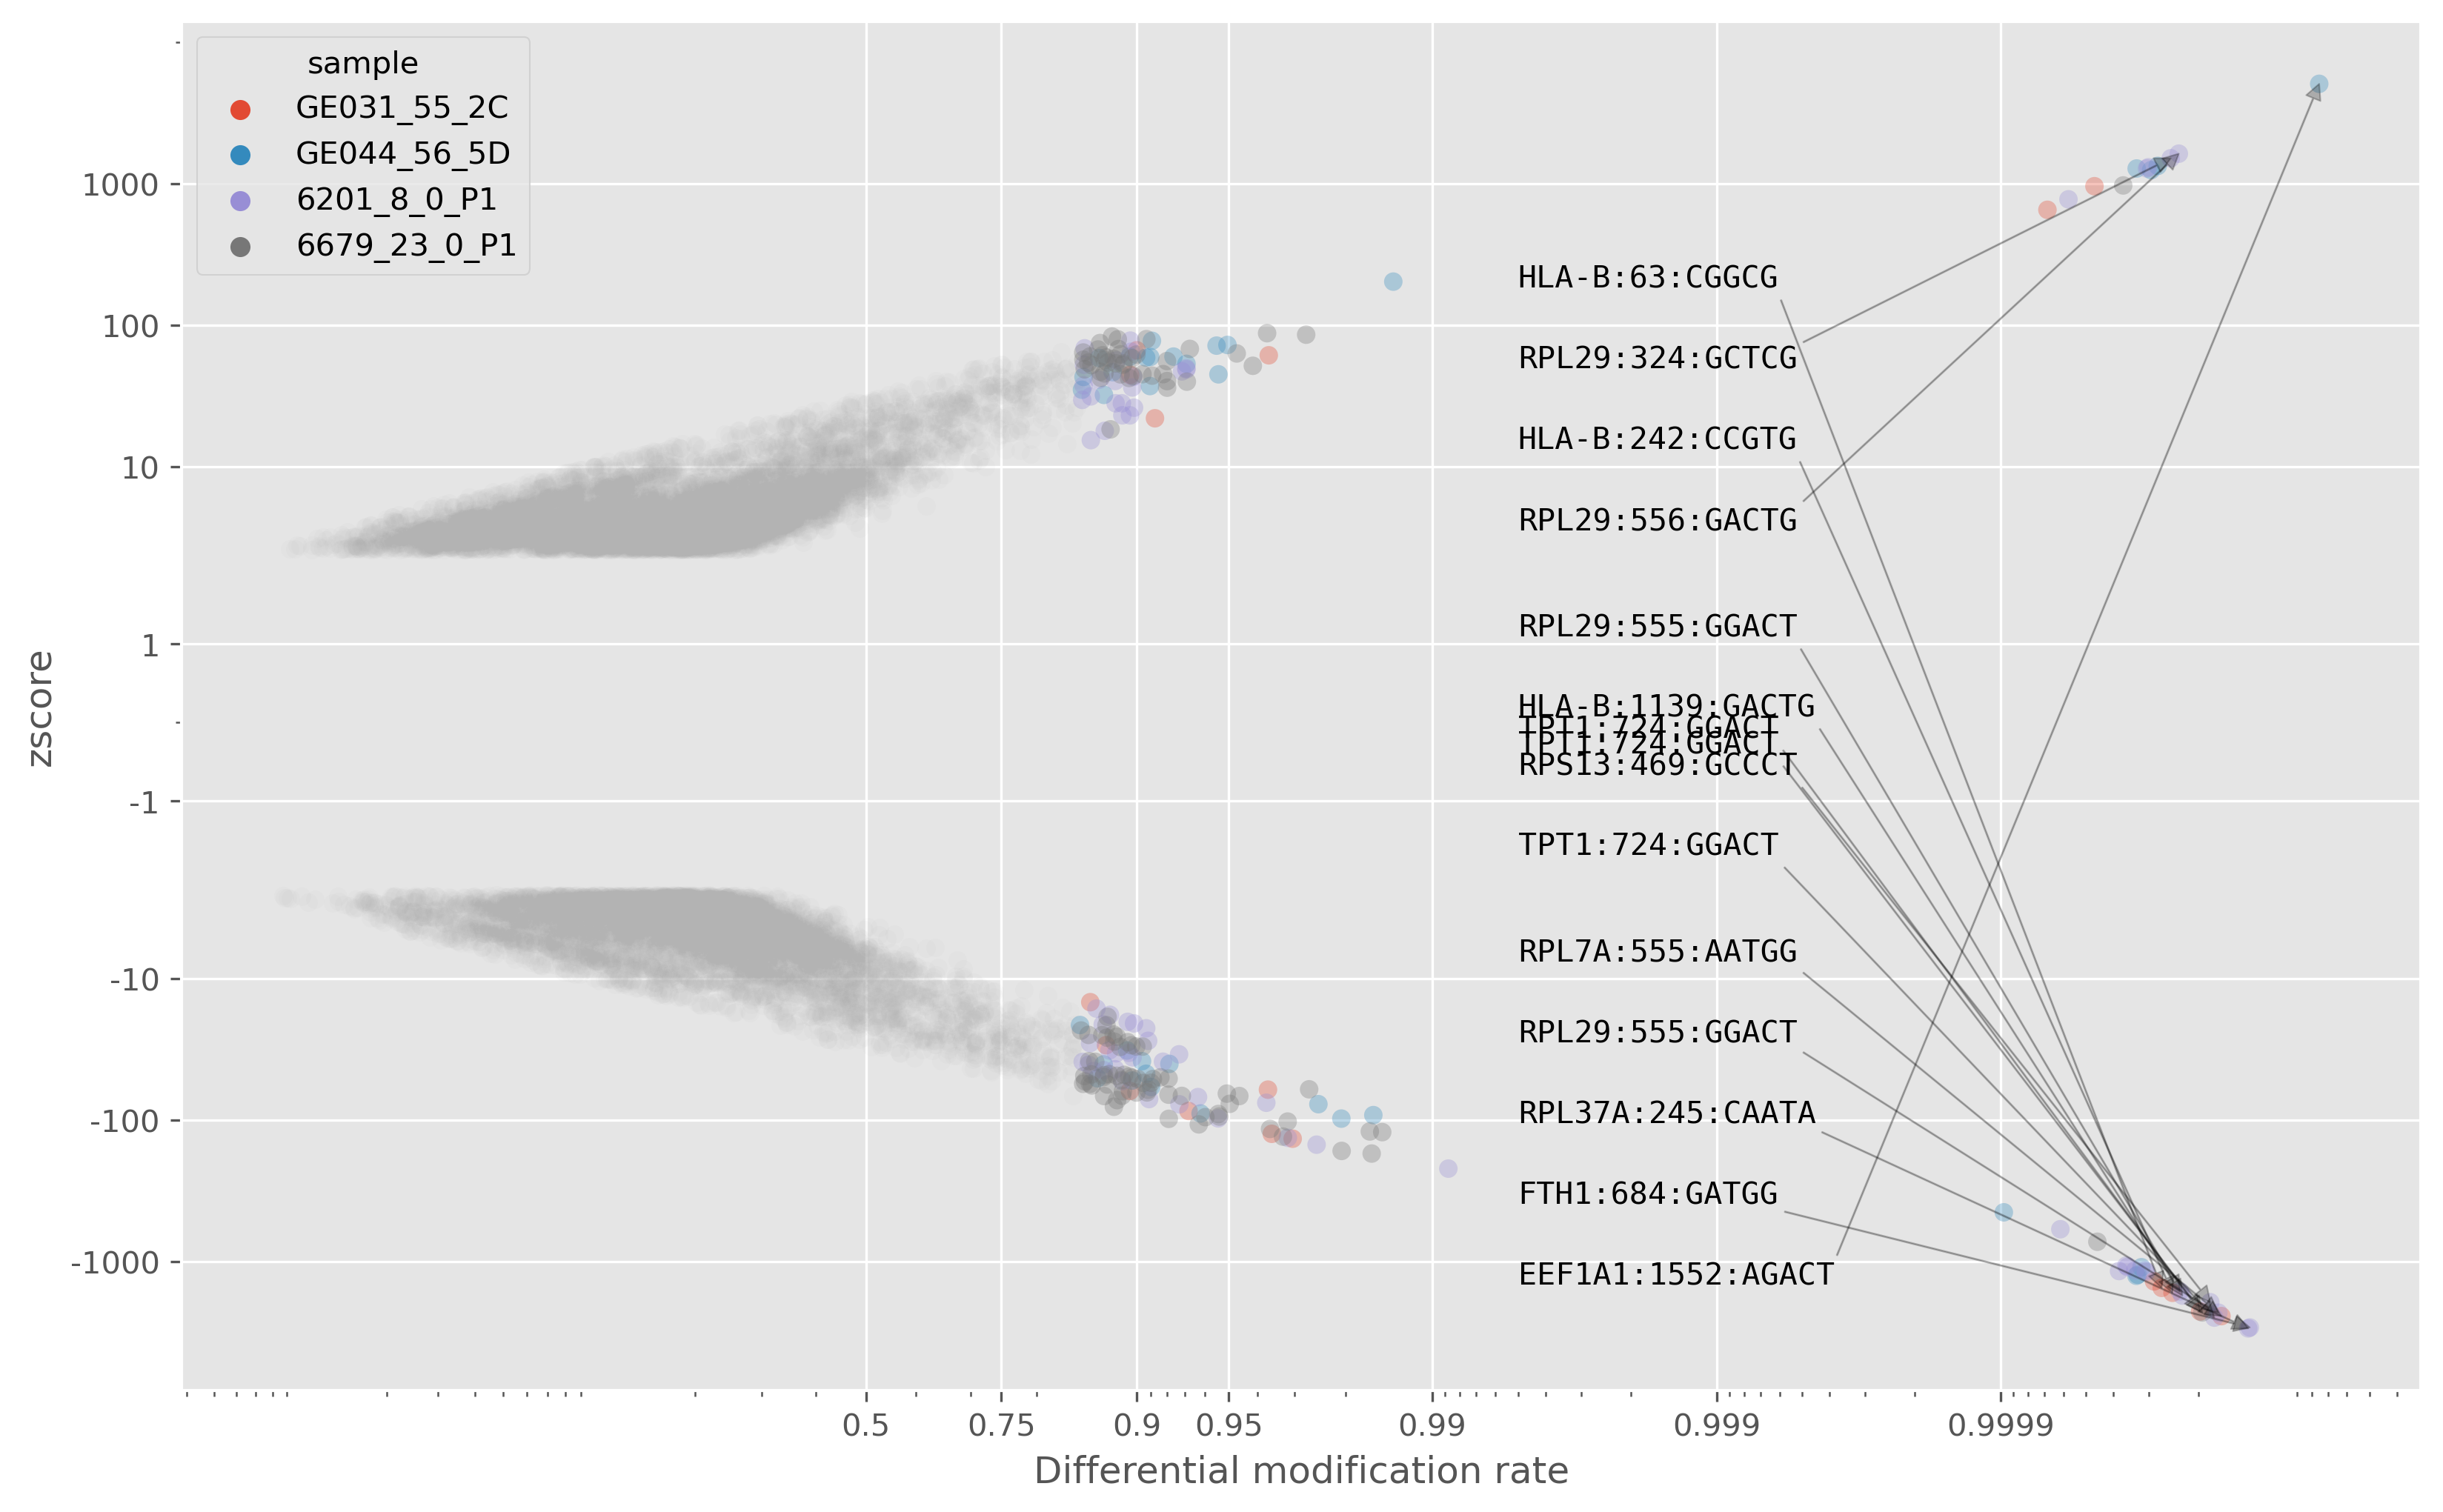

In [27]:
x = "diff_mod_rate"
y = "zscore"
hue = "sample"

x_sig = 0.85
data = xpore_df.copy()
data[x] = data[x].abs()  # absolute value of diff mod rate

non_sig_data = data.query(f"{x}<{x_sig}")
sig_data = data.query(f"{x}>={x_sig}")


fig, ax = plt.subplots()
sns.scatterplot(data=non_sig_data, x=x, y=y, linewidth=0, ax=ax, alpha=0.05, color="0.7")
sns.scatterplot(data=sig_data, x=x, y=y, hue=hue, linewidth=0, ax=ax, alpha=0.33)
ax.set_yscale("symlog")
ax.set_xscale("logit")
xticks = [0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
yticks = [-1000, -100, -10, -1, 1, 10, 100, 1000]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel("Differential modification rate")

n_annotations = 15
ypos = symlogspace(np.array(yticks), n_annotations)
xpos = 0.995
i = 0
for _, row in sig_data.nlargest(n_annotations, x).iterrows():
    label = f'{row["ref_id"]}:{row["pos"]}:{row["ref_kmer"]}'
    xx = row[x]
    yy = row[y]
    kmer = row["ref_kmer"]
    ax.annotate(label, 
                xy=(xx, yy), xycoords='data', 
                font="monospace",
                xytext=(xpos, ypos[i]), textcoords='data',
                horizontalalignment="left",
                verticalalignment="top",
                arrowprops=dict( 
                    color="black", 
                    alpha=0.25, 
                    width=0.25, 
                    headlength=5, 
                    headwidth=5,
                ))
    i += 1

In [28]:
sig_data.groupby(["sample"]).count()

,ref_id,pos,ref_kmer,diff_mod_rate,pvalue,zscore,mod_rate_CTRL-rep1,mod_rate_TEST-rep1,coverage_CTRL-rep1,coverage_TEST-rep1,mu_unmod,mu_mod,sigma2_unmod,sigma2_mod,conf_mu_unmod,conf_mu_mod,mod_assignment
sample,,,,,,,,,,,,,,,,,
6201_8_0_P1,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69
6679_23_0_P1,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108
GE031_55_2C,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
GE044_56_5D,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37


In [29]:
contents = dict()
for sample in infection:
    d = sig_data.query(f"sample=='{sample}'")
    contents[sample] = list(zip(d["ref_id"], d["pos"]))
    
xpore_upset_data = upsetplot.from_contents(contents)

[]

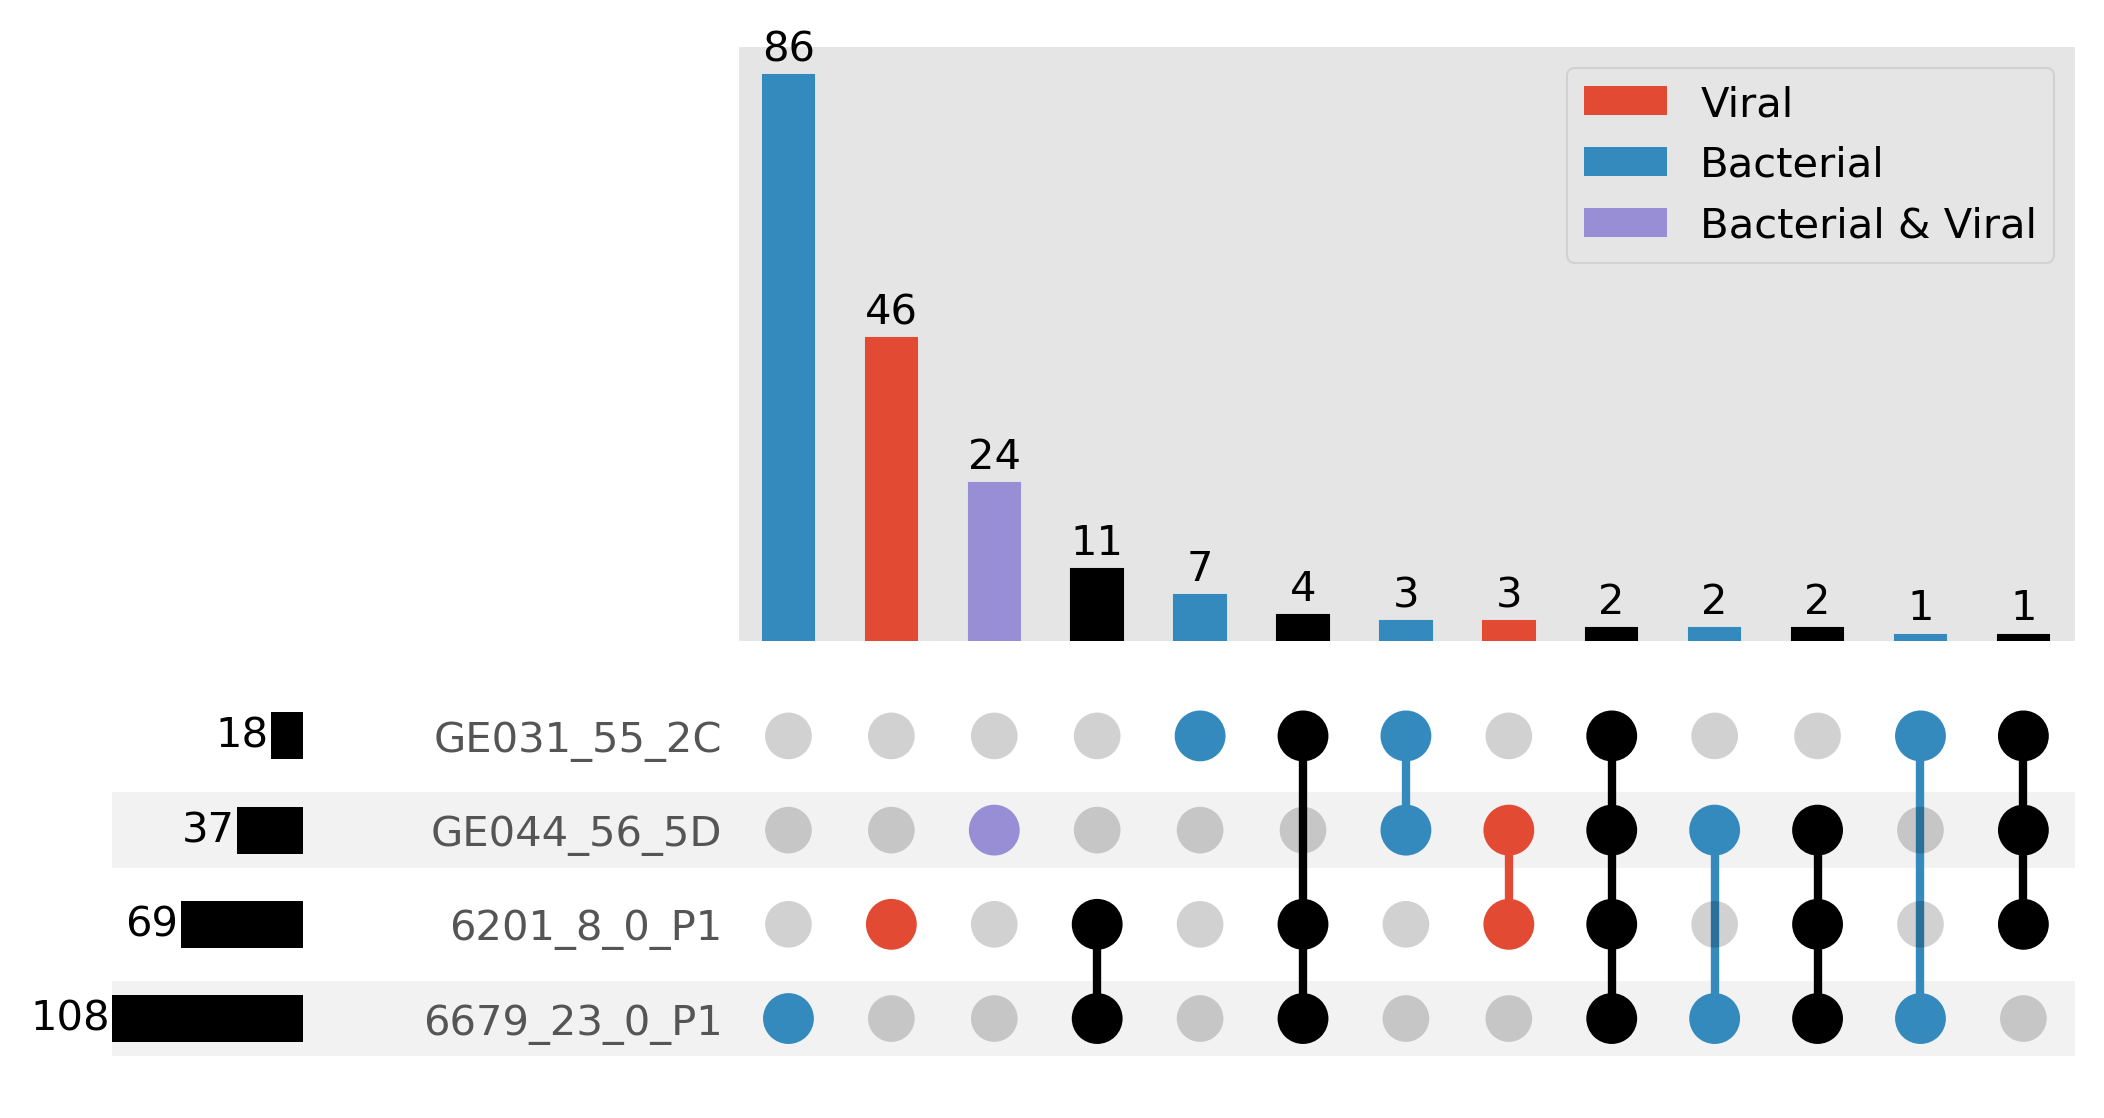

In [30]:
fig, ax = plt.subplots()
p = upsetplot.UpSet(xpore_upset_data, sort_by="cardinality", orientation="horizontal", show_counts=True)
# p.style_subsets(present=["GE044_56_5D"], label="Bacterial & Viral", facecolor=colours[2])
p.style_subsets(present=["6201_8_0_P1"], absent=["GE031_55_2C", "6679_23_0_P1"], label="Viral", facecolor=colours[0])
p.style_subsets(present=["6679_23_0_P1"], absent=["6201_8_0_P1"], label="Bacterial", facecolor=colours[1])
p.style_subsets(present=["GE031_55_2C"], absent=["6201_8_0_P1"], label="Bacterial", facecolor=colours[1])
p.style_subsets(present=["GE044_56_5D"], absent=[i for i in infection if i!="GE044_56_5D"], label="Bacterial & Viral", facecolor=colours[2])
p = p.plot(fig=fig)
p["intersections"].set_ylabel("")
p["intersections"].set_yticks([])
ax.axis("off")
p["totals"].set_xticks([])

## Overlapping significant positions

In [234]:
import networkx as nx
from itertools import combinations
from typing import Optional

In [235]:
D = 2

@dataclass(frozen=True)
class Position:
    gene: str
    pos: int
    sample: str
    tool: str
        
    def distance(self, other: Position) -> Optional[int]:
        if self.gene != other.gene:
            return None
        return abs(self.pos - other.pos)

In [236]:
xpore_sig_pos = set([Position(*t, "xpore") for t in zip(sig_data["ref_id"], sig_data["pos"], sig_data["sample"])])

In [237]:
len(xpore_sig_pos)

232

In [238]:
ncomp_sig_pos = set([Position(*t, "nanocompore") for t in zip(ncomp_df["ref_id"], ncomp_df["pos"], ncomp_df["sample"])])

In [239]:
len(ncomp_sig_pos)

406

In [240]:
all_sig_pos = ncomp_sig_pos.union(xpore_sig_pos)

In [241]:
len(all_sig_pos)

638

In [263]:
G = nx.Graph()

In [264]:
for u, v in combinations(all_sig_pos, r=2):
    d = u.distance(v)
    if d is None or d > D:
        continue
    G.add_edge(u, v, weight=d)

In [244]:
len(G.nodes)

351

In [245]:
len(G.edges)

403

The number of overlapping positions

In [246]:
nx.number_connected_components(G)

128

In [265]:
CC = list(nx.connected_components(G))
largest_cc = max(CC, key=len)

In [266]:
len(largest_cc)

10

In [267]:
largest_cc

{Position(gene='HLA-B', pos=181, sample='6201_8_0_P1', tool='nanocompore'),
 Position(gene='HLA-B', pos=183, sample='6201_8_0_P1', tool='xpore'),
 Position(gene='HLA-B', pos=183, sample='GE044_56_5D', tool='nanocompore'),
 Position(gene='HLA-B', pos=185, sample='6201_8_0_P1', tool='xpore'),
 Position(gene='HLA-B', pos=185, sample='GE031_55_2C', tool='xpore'),
 Position(gene='HLA-B', pos=185, sample='GE044_56_5D', tool='xpore'),
 Position(gene='HLA-B', pos=187, sample='6201_8_0_P1', tool='xpore'),
 Position(gene='HLA-B', pos=187, sample='GE031_55_2C', tool='nanocompore'),
 Position(gene='HLA-B', pos=188, sample='6201_8_0_P1', tool='xpore'),
 Position(gene='HLA-B', pos=189, sample='GE031_55_2C', tool='xpore')}

In [268]:
from collections import Counter
cc_sizes = Counter([len(c) for c in CC])
for d in sorted(cc_sizes):
    print(d, cc_sizes[d])

2 82
3 31
4 6
5 1
6 1
7 2
8 1
9 3
10 1


Remove CCs where all members are from the same sample and tool

In [269]:
for c in CC:
    s = {(u.sample, u.tool) for u in c}
    if len(s) == 1:
        G.remove_nodes_from(c)

In [270]:
len(G.nodes)

347

In [271]:
len(G.edges)

401

In [272]:
nx.number_connected_components(G)

126

So we only lost 2 positions from that filtering

In [273]:
CC = list(nx.connected_components(G))
cc_sizes = Counter([len(c) for c in CC])
for d in sorted(cc_sizes):
    print(d, cc_sizes[d])

2 80
3 31
4 6
5 1
6 1
7 2
8 1
9 3
10 1


In [283]:
H = G.copy()
for c in CC:
    tools = {u.tool for u in c}
    if len(tools) == 1:
        H.remove_nodes_from(c)

In [284]:
H_cc = list(nx.connected_components(H))

In [285]:
print(f"{len(H_cc)} CCs with both tools")

51 CCs with both tools


In [286]:
# add "dummy" edges between all members of CCs so we can remove excess nodes without losing connections
for c in nx.connected_components(H):
    for u, v in combinations(c, 2):
        H.add_edge(u, v, weight=0)

# remove sample-tool duplicates from clusters
nodes_to_remove = set()
for c in nx.connected_components(H):
    seen = set()
    for v in c:
        k = (v.tool, v.sample)
        if k in seen:
            nodes_to_remove.add(v)
        else:
            seen.add(k)

In [287]:
H.remove_nodes_from(nodes_to_remove)

In [288]:
def node_label(p: Position) -> str:
    return f"{p.gene}:{p.pos}"

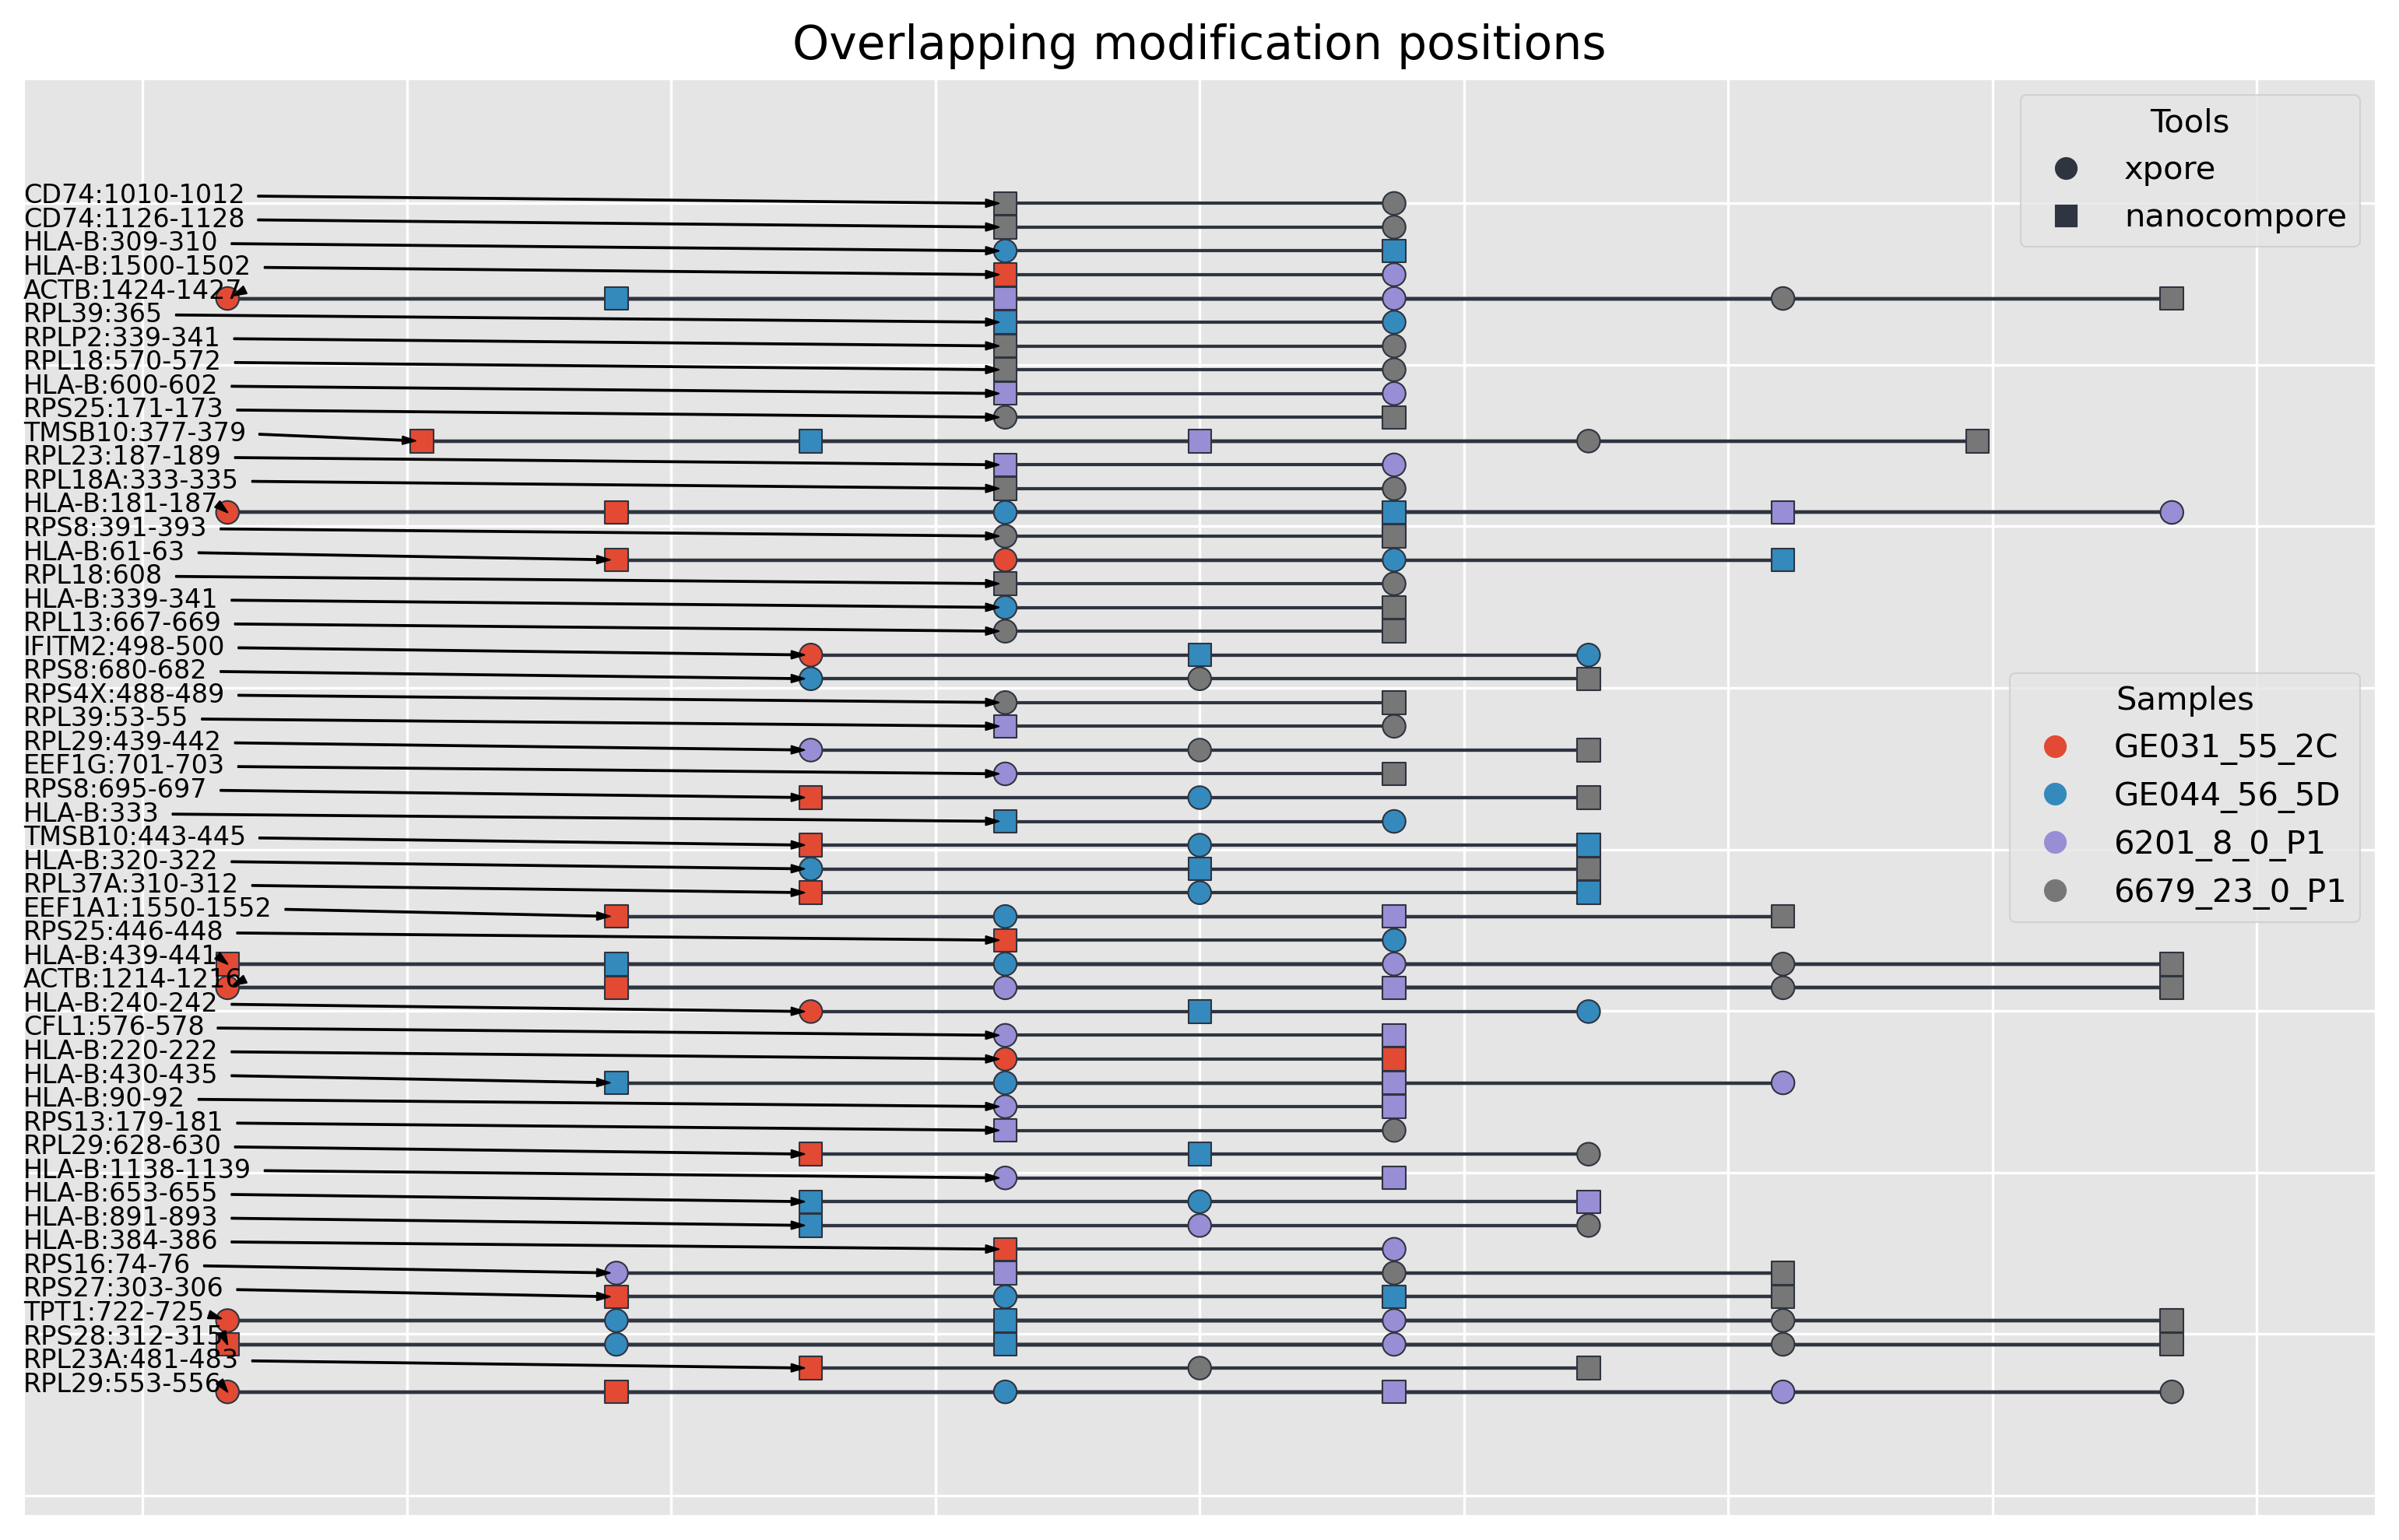

In [314]:
H_cc = list(nx.connected_components(H))
fig, ax = plt.subplots()

graph_layout = nx.multipartite_layout
black = "#2e3440"
node_colour_key = "node_colour"
label_key = "label"
align = "horizontal"
edge_colour = black
node_size = 50
edge_width = 1
font_size = 8
fw = "normal"
fc = black
subset_key = "cluster_id"

shapes = {"xpore": "o", "nanocompore": "s"}
sample_colours = {s: colours[i] for i, s in enumerate(infection)}
node_colours = {v: sample_colours[v.sample] for v in H.nodes}
# node_labels = {v: node_label(v) for v in H.nodes}

nx.set_node_attributes(H, node_colours, node_colour_key)
# nx.set_node_attributes(H, node_labels, label_key)

# add labeling of CCs for multipartite layout
cluster_ids = dict()
for i, cc in enumerate(H_cc):
    for v in cc:
        cluster_ids[v] = i
        
nx.set_node_attributes(H, cluster_ids, subset_key)

pos = graph_layout(H, subset_key=subset_key, align=align)

# sort the positions within each cluster so same samples are together
for c in H_cc:
    c_pos = {v: pos[v] for v in c}
    sorted_samples = sorted(c, key=lambda p: list(infection.keys()).index(p.sample))
    sorted_pos = sorted(list(map(list, c_pos.values())))
    for v, xy in zip(sorted_samples, sorted_pos):
        pos[v] = xy
    

for tool, shape in shapes.items():
    vs = [k for k, v in node_colours.items() if k.tool == tool]

    ps = {v: pos[v] for v in vs}
    cols = [H.nodes[v][node_colour_key] for v in vs]

    node_ax = nx.draw_networkx_nodes(
        H,
        pos=ps,
        nodelist=vs,
        node_color=cols,
        node_shape=shape,
        edgecolors=edge_colour,
        ax=ax,
        node_size=node_size,
    )

        
nx.draw_networkx_edges(H, pos, ax=ax, edge_color=edge_colour, width=edge_width)
# nx.draw_networkx_labels(
#     H, pos, ax=ax, font_size=font_size, font_weight=fw, font_color=fc, labels=node_labels, 
# )
xpos = ax.get_xlim()[0]
arrowprops=dict( 
                color="black", 
                arrowstyle="simple, head_length=0.5, head_width=0.3, tail_width=0.05",
                relpos=(1, 0.5)
                )

cluster_labels = []
for cc in map(list, H_cc):
    _, ypos = pos[cc[0]]
    min_xpos = min(pos[v][0] for v in cc)
    gene = cc[0].gene
    gene_positions = [v.pos for v in cc]
    min_pos = min(gene_positions)
    max_pos = max(gene_positions)
    if min_pos == max_pos:
        label = f"{gene}:{min_pos}"
    else:
        label = f"{gene}:{min_pos}-{max_pos}"
    cluster_labels.append(label)
    xytext = (xpos, ypos)
    xy = (min_xpos, ypos)
#     ax.text(xpos, ypos, label, fontsize=font_size)
    ax.annotate(label, xy=xy, xytext=xytext, arrowprops=arrowprops, fontsize=font_size)

ax.set_title("Overlapping modification positions")

# legend
patches = []
fakexy = (0, 0)
for k, shape in shapes.items():
    patch = plt.Line2D(fakexy, fakexy, linestyle='none', marker=shape, label=k, color=black)
    patches.append(patch)

tool_leg = plt.legend(handles=patches, title="Tools", loc="upper right")
    
patches = []
for sample, colour in sample_colours.items():
    patch = plt.Line2D(fakexy, fakexy, linestyle='none', marker="o", label=sample, color=colour)
    patches.append(patch)
    
plt.legend(handles=patches, title="Samples", loc="center right")
plt.gca().add_artist(tool_leg)

In [319]:
from collections import defaultdict
labels = defaultdict(list)
for l in sorted(cluster_labels):
    gene, pos = l.split(":")
    labels[gene].append(pos)
    
for gene, poss in labels.items():
    print(gene, sorted(poss, key=lambda s: int(s.split("-")[0])))

ACTB ['1214-1216', '1424-1427']
CD74 ['1010-1012', '1126-1128']
CFL1 ['576-578']
EEF1A1 ['1550-1552']
EEF1G ['701-703']
HLA-B ['61-63', '90-92', '181-187', '220-222', '240-242', '309-310', '320-322', '333', '339-341', '384-386', '430-435', '439-441', '600-602', '653-655', '891-893', '1138-1139', '1500-1502']
IFITM2 ['498-500']
RPL13 ['667-669']
RPL18 ['570-572', '608']
RPL18A ['333-335']
RPL23 ['187-189']
RPL23A ['481-483']
RPL29 ['439-442', '553-556', '628-630']
RPL37A ['310-312']
RPL39 ['53-55', '365']
RPLP2 ['339-341']
RPS13 ['179-181']
RPS16 ['74-76']
RPS25 ['171-173', '446-448']
RPS27 ['303-306']
RPS28 ['312-315']
RPS4X ['488-489']
RPS8 ['391-393', '680-682', '695-697']
TMSB10 ['377-379', '443-445']
TPT1 ['722-725']
